# BERTopic

## imports and preliminaries

In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download('punkt_tab')

path_to_data = "./text_chunks.tsv"
stopwords = stopwords.words("english")
stopwords.extend(["the", "in", "of"])

#print(stopwords)

# Open training data
training_data = pd.read_csv(path_to_data, sep="\t", header=0)

# Tokenise text and remove stopwords
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: word_tokenize(x))
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: ' '.join([word for word in x if word.lower() not in stopwords]))

#training_data.head(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## So, is there an ERNIETopic?

In [2]:
# prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(training_data["TEXT"], show_progress_bar=True)
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# Train BERTopic
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(training_data["TEXT"])
hierarchical_topics = topic_model.hierarchical_topics(training_data["TEXT"])

# Save model
topic_model.save("./output/bertopic_model", serialization="safetensors", save_ctfidf=True)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-11-18 16:11:38,199 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

2024-11-18 16:11:50,243 - BERTopic - Embedding - Completed ✓
2024-11-18 16:11:50,244 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-18 16:11:56,047 - BERTopic - Dimensionality - Completed ✓
2024-11-18 16:11:56,048 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-18 16:11:56,113 - BERTopic - Cluster - Completed ✓
2024-11-18 16:11:56,120 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-18 16:11:56,232 - BERTopic - Representation - Completed ✓
100%|██████████| 50/50 [00:00<00:00, 771.32it/s]


In [3]:
topic_model.get_document_info(training_data["TEXT"])

similar_topics, similarity = topic_model.find_topics("composition", top_n=5)
topic_model.get_topic(similar_topics[0])

[('composition', 0.1930495759702055),
 ('everything', 0.13725239881981527),
 ('different', 0.08980389850993527),
 ('naturally', 0.08566788808115343),
 ('beginning', 0.08380106978231557),
 ('time', 0.08114608605133054),
 ('thing', 0.070238229356108),
 ('simply', 0.061504989217734424),
 ('continuous', 0.06008772210791298),
 ('alike', 0.05885992471706433)]

[[8.712115  5.8642654]
 [8.60949   5.747189 ]
 [9.199866  2.5999417]
 ...
 [9.136371  3.2420466]
 [8.279589  2.3957021]
 [9.147509  2.7726336]]


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


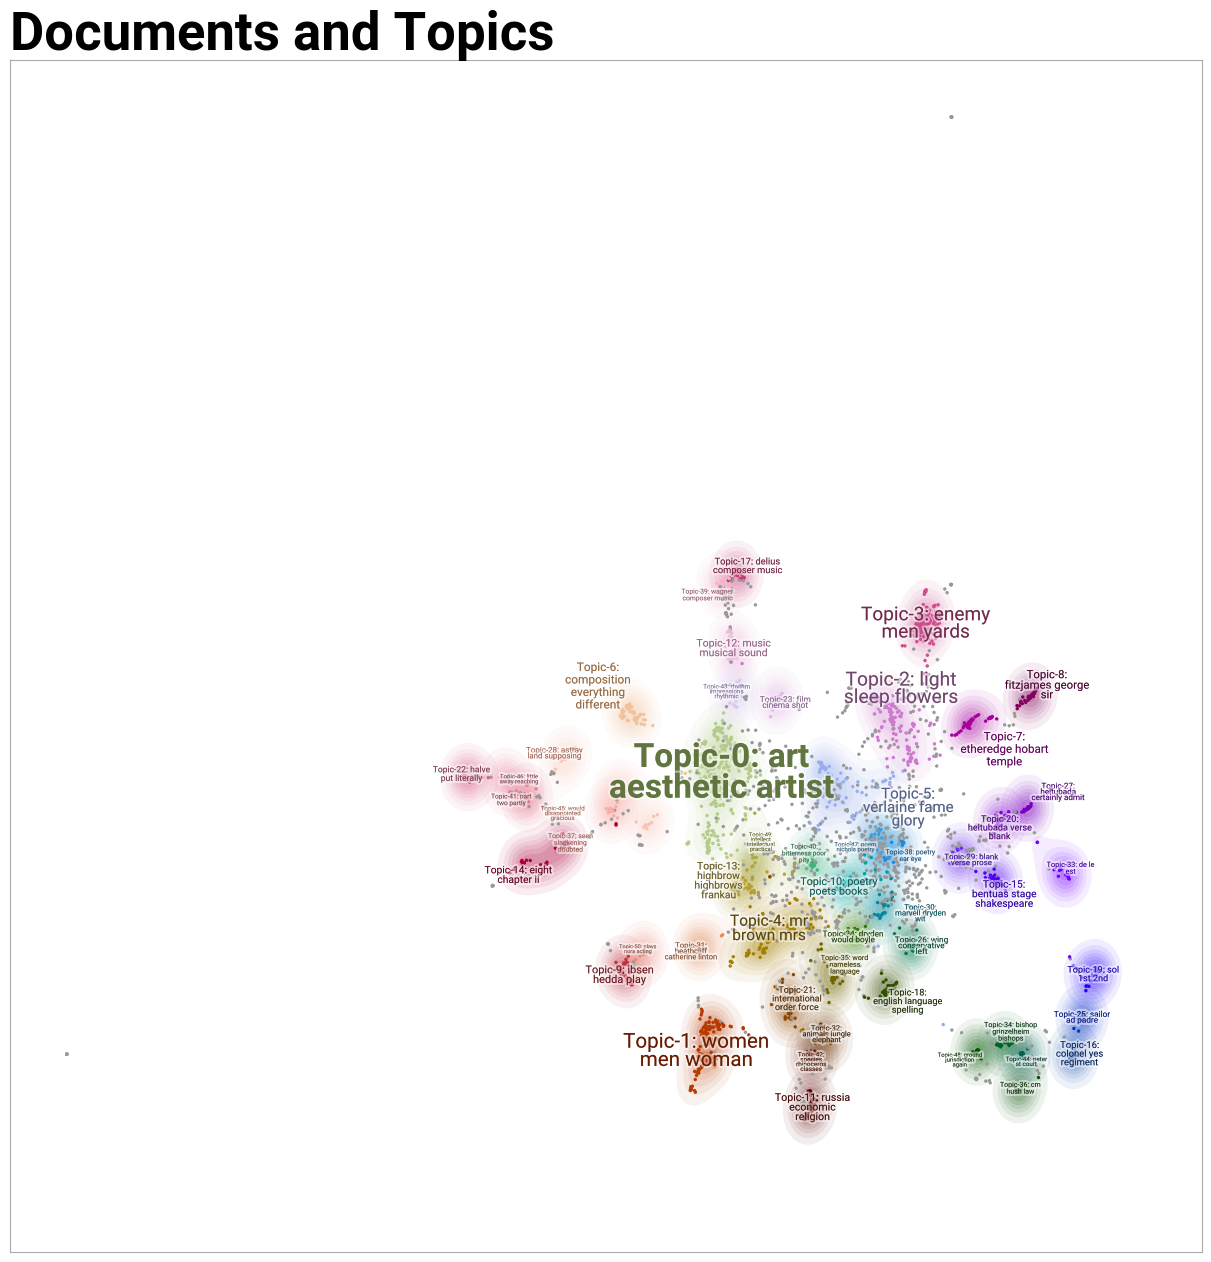

In [12]:
topic_model.load("./output/bertopic_model")
docs = training_data["TEXT"]
#reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

datamap = topic_model.visualize_document_datamap(
  docs, 
  reduced_embeddings=reduced_embeddings,
  label_over_points=True, 
  dynamic_label_size=True)

#datamap.savefig("./output/datamap.png")